# Info
This is the main answer to this project. Below is where all findings are accumulated to give the most accurate answers. For process' and results see attachements.

# 1. Functions for generating synthetic input data

## Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random as rnd
from datetime import datetime as dt

## Example functions

In [ ]:
def F2(y):
    return 0.5*y**2


def Fcos(y):
    return 1 - np.cos(y)


def F22(y1, y2):
    return 0.5*(y1**2 + y2**2)


def Fsqrt(y1, y2):
    return - 1 / np.sqrt(y1**2 + y2**2)

## Numerical functions for Hamiltonian systems

In [ ]:
# We wish to find how qn, pn changes with n, and therefore how the hamiltonian changes
# along the n-values


# Examples of seperable Hamiltonian problems
# T:The kinetic energy
# V:The potensial energy


# T and V for the hamiltonian in nonlinear pendelum
def T_H_1(p):
    return (1/2)*p**2


def V_H_1(q):
    return m*g*l*(1-np.cos(q))

# T and V for the Hamiltonian in Kepler's two-body problem


def T_H_2(x):
    return (1/2)*np.dot(np.transpose(x), x)


def V_H_2(y):
    return -((1)/(np.sqrt(y[0]**2+y[1]**2)))

# T and V for the Hamiltonian in Henon-heile's problem


def T_H_3(p):
    return (1/2)*np.dot(np.transpose(p), p)


def V_H_3(q):
    return (1/2)*np.dot(np.transpose(q), q)+(q[0]**2)*q[1]-(1/3)*q[1]**3


# 2. Implementation of the neural network and optimizers

In [ ]:
def σ(x):
    return np.tanh(x)


def dσ(x):
    # return 1 / np.cosh(x)**2 # our
    return 1.0 - np.tanh(x) ** 2


def η(x):  # max [0, 1]
    return (1.0 + np.tanh(x / 2.0)) / 2.0


def dη(x):
    # return 1/(2 * np.cosh(x) + 2) # our
    return 0.25 * (1.0 - np.tanh(x / 2.0) ** 2)

class Model():
    """Base model:
        It holds startup informasjon about the model and the network used in this method.
    """

    def __init__(self, Y0, C, K, weigths=None):
        """Set values"""
        self.d = len(Y0)
        self.I = len(Y0[0])
        self.C = C  # Ska denna vær init her?
        self.K = K
        self.h = None
        self.j = 0  # Iterations
        self.Υ = np.zeros_like(self.C)
        self.Y0 = Y0
        self.ΥmC = self.Υ - self.C
        self.Jθ = 0.5 * np.linalg.norm(self.Υ - self.C)**2
        self.Jθlog = []
        if weigths:  # Imports weigths
            self.startθ = weigths
        else:  # set random weights
            self.startθ = {'W': np.random.rand(self.K, self.d, self.d),
                           'b': np.random.rand(self.K, self.d, 1),
                           'w': np.random.rand(self.d, 1),
                           'μ': np.random.rand()}
        """Memory allocation"""
        self.θ = self.copyWeights(self.startθ)
        self.Z = np.zeros((K+1, self.d, self.I))
        self.Z[0] = Y0
        # One less than intended bc P[0] is not used
        self.P = np.zeros((K, self.d, self.I))
        self.dθ = {'W': np.zeros((self.K, self.d, self.d)),
                   'b': np.zeros((self.K, self.d, 1)),
                   'w': np.zeros((self.d, 1)),
                   'μ': 0}

    def __repr__(self):
        pass

    def __len__(self):
        return self.I

    def copyWeights(self, weights):
        θ = {'W': weights['W'].copy(),
             'b': weights['b'].copy(),
             'w': weights['w'].copy(),
             'μ': weights['μ']}
        return θ

    def copy(self):
        θ = self.copyWeights(self.θ)
        return Model(self.Y0.copy(), self.C.copy(), self.K, θ)

    def computeZ(self):  # (4)
        W = self.θ['W']
        b = self.θ['b']
        h = self.h
        K = self.K
        for k in range(K):
            self.Z[k+1] = self.Z[k] + h * σ(W[k] @ self.Z[k] + b[k])

    def backwardPropagation(self):
        W = self.θ['W']
        b = self.θ['b']
        w = self.θ['w']
        μ = self.θ['μ']
        K = self.K
        Z = self.Z
        h = self.h
        K = self.K
        # Save computation
        Zxw = Z[-1].T @ w + μ
        # Update variables (Approximation)
        self.Υ = η(Zxw).T  # (5)
        self.ΥmC = self.Υ - self.C
        self.Jθ = 0.5*np.linalg.norm(self.ΥmC)**2
        # Compute last P[K]
        self.P[self.K-1] = np.outer(w, (self.ΥmC * dη(Zxw).T))  # (10) (verified)
        """Backward propagation"""
        for k in range(K-1, 0, -1):  # Change P index to K+1
            self.P[k-1] = self.P[k] + h*W[k].T @ (dσ(W[k] @ Z[k] + b[k]) * self.P[k])  # (11)

    def computeGradients(self):
        W = self.θ['W']
        b = self.θ['b']
        w = self.θ['w']
        μ = self.θ['μ']
        Z = self.Z
        P = self.P
        h = self.h
        K = self.K
        # save computation
        dηZw = dη(Z[K].T @ w + μ)
        # compute (8) and (9)
        self.dθ['μ'] = dηZw.T @ self.ΥmC.T
        self.dθ['w'] = Z[K] @ (self.ΥmC.T * dηZw)
        # Compute (12) and (13)
        for k in range(K):
            # Save computation
            PhadσWZ = h * P[k] * dσ(W[k] @ Z[k] + b[k])
            self.dθ['W'][k] = PhadσWZ @ Z[k].T
            self.dθ['b'][k] = PhadσWZ @ np.ones((self.I, 1))

    def update(self):
        self.computeZ()
        self.backwardPropagation()
        self.computeGradients()

    def setInput(self, Y0, C):
        self.Y0 = Y0.copy()
        self.d = len(Y0)
        self.I = len(Y0[0])
        self.Z = np.zeros((self.K+1, self.d, self.I))
        self.Z[0] = Y0.copy()
        self.P = np.zeros((self.K, self.d, self.I))
        self.C = C.copy()
        self.Υ = np.zeros_like(self.C)
        self.ΥmC = self.Υ - self.C
        self.Jθ = 0.5 * np.linalg.norm(self.Υ - self.C)**2
        self.j = 0

    def restart(self):
        self.θ = self.copyWeights(self.startθ)
        self.j = 0
        self.Υ = np.zeros_like(self.C)
        self.ΥmC = self.Υ - self.C
        self.Jθ = 0.5 * np.linalg.norm(self.Υ - self.C)**2

    def gradTest(self, Y0):
        Z = np.zeros_like(self.Z)
        Z[0] = Y0

    def getGrads(self, Z=np.array([])):
        h = self.h
        K = self.K
        W = self.θ['W']
        b = self.θ['b']
        w = self.θ['w']
        μ = self.θ['μ']
        if len(Z)==0:
            Z = self.Z.copy()

        # algorithm
        A = np.dot(w, dη(np.dot(w.T, Z[K]) + μ))
        for k in range(K, 0, -1):
            A = A + W[k-1].T @ (h * dσ(W[k-1] @ Z[k-1] + b[k-1]) * A)
        return A

    def computeGradYn(self, y):
        W = self.θ['W']
        b = self.θ['b']
        K = self.K
        h = self.h
        vec = np.zeros((K+1, self.d, 1))
        vec[0] = y
        for k in range(K):
            core = h * σ(W[k] @ vec[k] + b[k])
            vec[k+1] = vec[k] + core
        return self.getGrads(vec)
        

class Adam():
    def __init__(self, model, h=None, tol=None, maxiter=None):
        self.M = model
        self.M.h = h
        self.tol = tol
        self.maxiter = maxiter
        self.m = {'W': np.zeros((model.K, model.d, model.d)),
                  'b': np.zeros((model.K, model.d, 1)),
                  'w': np.zeros((model.d, 1)),
                  'μ': 0}
        self.v = self.m.copy()

    def __repr__(self):
        # re = f'Adam, h={self.M.h}, K={self.M.K}, iter={self.maxiter}, Jθ={round(self.M.Jθ, 5)}'
        re = 'Adam'
        return re

    def name(self):
        return 'Adam'

    def algo(self):
        β1 = 0.9
        β2 = 0.999
        α = 0.01
        ϵ = 1e-8
        for key in self.m.keys():
            self.m[key] = β1*self.m[key] + (1-β1)*self.M.dθ[key]
            self.v[key] = β2*self.v[key] + (1-β2)*np.square(self.M.dθ[key])

            m = self.m[key] / (1 - β1**self.M.j)
            v = self.v[key] / (1 - β2**self.M.j)
            self.M.θ[key] -= α * m / (np.sqrt(v) + ϵ)

    def run(self, h, tol, maxiter):
        self.M.h = h
        self.tol = tol
        self.maxiter = maxiter
        self.M.update()
        # while self.M.Jθ > tol and self.M.j <= maxiter:
        while self.M.j <= maxiter:
            self.M.j += 1
            self.algo()
            self.M.update()
        self.M.Jθlog.append([self.M.h, self.M.Jθ])

    def setParams(self, h, tol, maxiter):
        self.h = h
        self.tol = tol
        self.maxiter = maxiter

    def _restart_m_and_v(self):
        self.m = {'W': np.zeros((self.M.K, self.M.d, self.M.d)),
                  'b': np.zeros((self.M.K, self.M.d, 1)),
                  'w': np.zeros((self.M.d, 1)),
                  'μ': 0}
        self.v = self.m.copy()

    def continueRun(self):
        self._restart_m_and_v()
        self.M.j = 0
        self.run(self.M.h, self.tol, self.maxiter)


class PVGD():
    """Plain Vanilla Gradient Descent optimizer
    """

    def __init__(self, model):
        self.M = model
        self.τ = None
        self.maxiter = None
        self.log = {}

    def __repr__(self):
        # re = f'PVGD, h={self.M.h}, τ={self.τ}, K={self.M.K}, iter={self.M.j}, Jθ={round(self.M.Jθ, 5)}'
        re = 'PVGD'
        return re

    def name(self):
        return 'PVGD'

    def run(self, h, τ, tol, maxiter, ):
        self.M.h = h
        self.τ = τ
        self.maxiter = maxiter
        self.log[(τ, maxiter)] = []
        while self.M.Jθ > tol and self.M.j < maxiter:
            self.M.j += 1
            self.M.update()
            for key in self.M.θ:
                self.M.θ[key] -= self.τ * self.M.dθ[key]
                # if self.M.j % 10 == 0:
                #     self.log[(τ, maxiter)].append(self.M.Jθ)
            # self.plotProg()

    def plotProg(self):
        if self.M.j % 1000 == 0:
            # plt.plot(self.log[(self.τ, self.maxiter)][:][1], self.log[(self.τ, self.maxiter)][:][0])
            plt.plot(self.M.γ)
            plt.title(f'{self.log.keys()}')
            plt.show()



class SGD():
    """Stochastic Gradient Descent method on chosen optimizer
    """

    def __init__(self, opt, n=None):
        # Extract the total input and exact output
        self.opt = opt
        self.M = opt.M
        self.Yt = opt.M.Y0
        self.Ct = opt.M.C
        self.maxiter = opt.maxiter
        # SGD's own variables
        self.jt = 0
        self.subsets = {}
        self.n = n

    def __repr__(self):
        pass

    def separate(self, n):
        self.n = n
        self.opt.maxiter = int(self.maxiter/n)
        for i in range(n):
            self.subsets[i] = []

        YtCt = []
        for i in range(len(self.Ct)):
            YtCt.append([self.Yt[:, i], self.Ct[i]])

        i = 0
        while YtCt:
            r = np.random.randint(0, len(YtCt))
            self.subsets[i].append(YtCt.pop(r))
            i += 1
            if i == self.n:
                i = 0

    def run(self):

        for YC in self.subsets.values():
            Y0 = []
            C = []
            for YCi in YC:
                Y0.append(YCi[0])
                C.append(YCi[1])
            Y0 = np.array(Y0).T
            C = np.array(C)
            self.M.setInput(Y0, C)
            self.opt.continueRun()
        self.M.setInput(self.Yt, self.Ct)
        self.M.update()

    def continueRun(self):
        self.separate(self.n)
        self.run()

    def name(self):
        return 'SGD ' + self.opt.name()
    
    def setInput(self, Y0, C):
        self.Yt = Y0.copy()
        self.Ct = C.copy()
   

## (a) Test model on suggested functions
The results of the models behaviour on synthetic data are shown in "modelTest.ipynb". 
## (b) Find optimal $K$, $\tau$, $d$ and $h$ for PVGD and Adam
For the process and results behind this section see "paramSearch.ipynb". Since, just by the modelTest results, the Adam method show best results it is chosen to use this method for the majority of the project. Regarding the $h$ parameter the results tend to be better for values as large as $h = 0.5$. When it comes to the plain vanilla gradient descent it seems to be a very sensitive correlation between all of the parameters. Thus, by chosing wrong parameters you will not converge.
## (c) Train the model for the case of given data


### Supplemented function

In [ ]:
import csv
import numpy as np
from ast import literal_eval
import re

def generate_data(batch=0):
    """Generates one dict with data from one batch

    Args:
        batch (int, optional): Batch number. Defaults to 0.

    Returns:
        Dictionary: Keys: t, Q, P, T, V
    """

    start_path = ""
    path = start_path+"project_2_trajectories/datalist_batch_" + \
        str(batch)+".csv"
    with open(path, newline="\n") as file:
        reader = csv.reader(file)
        datalist = list(reader)

    N = len(datalist)
    t_data = np.array([float(datalist[i][0]) for i in range(1, N)])
    Q1_data = [float(datalist[i][1]) for i in range(1, N)]
    Q2_data = [float(datalist[i][2]) for i in range(1, N)]
    Q3_data = [float(datalist[i][3]) for i in range(1, N)]
    P1_data = [float(datalist[i][4]) for i in range(1, N)]
    P2_data = [float(datalist[i][5]) for i in range(1, N)]
    P3_data = [float(datalist[i][6]) for i in range(1, N)]
    T_data = np.array([float(datalist[i][7]) for i in range(1, N)])
    V_data = np.array([float(datalist[i][8]) for i in range(1, N)])

    Q_data = np.transpose(
        np.array([[Q1_data[i], Q2_data[i], Q3_data[i]] for i in range(N-1)]))
    P_data = np.transpose(
        np.array([[P1_data[i], P2_data[i], P3_data[i]] for i in range(N-1)]))

    return {"t": t_data, "Q": Q_data, "P": P_data, "T": T_data, "V": V_data}

### Training function and more

In [ ]:
def scale(y, α=0, β=1):
    b = np.max(y)
    a = np.min(y)
    return ((b - y)*α + (y - a)*β) / (b-a)


def scaleBack(sy, c, α=0, β=1):
    b = np.max(c)
    a = np.min(c)
    return sy*(b - a)/(β - α) - (b*α - a*β)/(β-α)


def scaleBackGrad(c, α, β):
    a = np.min(c)
    b = np.max(c)
    return (b-a) / (β - α)

def plotApprox(C, *args, x=np.array([])):
    """Plots optimzers best approximation to one set of training data

    Args:
        C       (ndarray)          : The exact value
        *args   (tuple)            : tuple of optimized models that should be compared
        x       (ndarray, optional): The x-axis of the training data. Defaults to np.array([]).
    """
    if len(x) == 0:
        x = np.linspace(0, 1, args[0].M.I)
    for mod in args:
        lbl = mod.name()
        if lbl == 'PVGD':
            lbl += ', h={}, τ={}, J(θ)={}'.format(mod.M.h, mod.τ, round(mod.M.Jθ, 3))
        else:
            lbl += ', h={}, J(θ)={}'.format(mod.M.h, round(mod.M.Jθ, 3))

        plt.plot(x, scaleBack(mod.M.Υ[0], C), label=lbl, linewidth=3)

    if C.shape[0] == 1:
        plt.plot(x, C[0], label='F(y)', ls='--')
    else:
        plt.plot(x, C, label='F(y)', ls='--')
    plt.title(r'Comparing $\tilde{F}(y)$ with $F(y)$')
    plt.legend()
    plt.show()


def train(opt, bfrom, bTo, dFrom, dTo, inp='Q', output='V'):
    print(f'Training on batch {bfrom}-{bTo} with {dTo - dFrom} datapoints.\n'
          f'Input: {inp}, output: {output}, iterations: {opt.maxiter}, Layers: {opt.M.K}')
#     print('Batch\tJ(θ)')
    Jθlist = []
    start = dt.now()
    for i in range(bfrom, bTo+1):
        # try:
        batch = generate_data(i)
        Y0 = np.array(batch[inp][:, dFrom:dTo])
        C = np.array(batch[output][dFrom:dTo])
        Cscaled = scale(C.copy())
        if opt.name().startswith('SGD'):
            opt.setInput(Y0, C)
        else:
            opt.M.setInput(Y0, Cscaled)
        opt.continueRun()
        Jθlist.append(opt.M.Jθ)
#             print(f'{i}\t{round(opt.M.Jθ, 5)}')
            # t = batch['t'][dFrom:dTo] # used for plot approx
            # plotApprox(C, opt, x=t)
        # except Exception as exc:
        #     print('Error occured on batch {}:\n{}'.format(i, exc))
    end = dt.now()
    print('Training time:', end-start)
    return Jθlist

def testOnNew(Y, C, t, m):
    Z = Y.copy()
    θ = m.M.θ

    for k in range(m.M.K):
        Z = (Z + m.M.h * σ(θ['W'][k] @ Z + θ['b'][k]))
    Υ = η(Z.T @ θ['w'] + θ['μ']).T[0]

    Jθ = 0.5*np.linalg.norm(Υ - scale(C))**2

    plt.title(r'Trained on new input, $J(\theta) = {}$'.format(round(Jθ, 4)))
    plt.plot(t, scaleBack(Υ, C), label=r'$\tilde{F}(y)$')
    plt.plot(t, C, ls='--')
    plt.legend()
    plt.show()

### Setup
We chose to use Adam descent for our primary optimizer.
The params are chosen according to the findings in the parameter search process

In [ ]:
# Setup model to train on the potential energy of the hamiltonian
modV = Model(np.array([[1, 2, 3], [1, 2, 3], [1, 2, 3]]), np.array([1, 2, 3]), 30)
adamOptV = Adam(modV.copy(), h=0.2, tol=1e-5, maxiter=300)

In [ ]:
# Setup model to train on the potential energy of the hamiltonian
modT = Model(np.array([[1, 2, 3], [1, 2, 3], [1, 2, 3]]), np.array([1, 2, 3]), 30)
adamOptT = Adam(modT.copy(), h=0.2, tol=1e-5, maxiter=300)

### Training

In [ ]:
batchFrom = 0 # included
batchTo = 29 # included
dataPointsFrom = 0
dataPointsTo = 4096
"""Potential"""
JθV = train(adamOptV, batchFrom, batchTo, dataPointsFrom, dataPointsTo)

Training on batch 0-29 with 4096 datapoints.
Input: Q, output: V, iterations: 300, Layers: 30
Training time: 0:09:42.453499


In [ ]:
"""Kinetic"""
JθT = train(adamOptT, batchFrom, batchTo, dataPointsFrom, dataPointsTo, 'P', 'T')

Training on batch 0-29 with 4096 datapoints.
Input: P, output: T, iterations: 300, Layers: 30
Training time: 0:09:22.010295


Cell below show the convergence plot for both kinetic and potential training

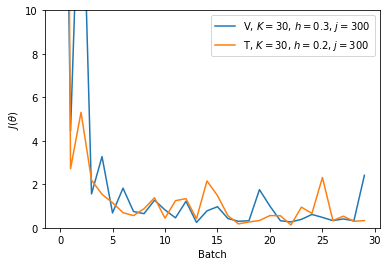

In [ ]:
plt.plot(JθV, label=r'V, $K={}$, $h={}$, $j={}$'
         ''.format(adamOptV.M.K, adamOptV.M.h, adamOptV.maxiter))
plt.plot(JθT, label=r'T, $K={}$, $h={}$, $j={}$'
         ''.format(adamOptT.M.K, adamOptT.M.h, adamOptT.maxiter))
plt.legend()
plt.ylabel(r'$J(\theta)$')
plt.xlabel('Batch')
plt.ylim(0, 10)
plt.show()

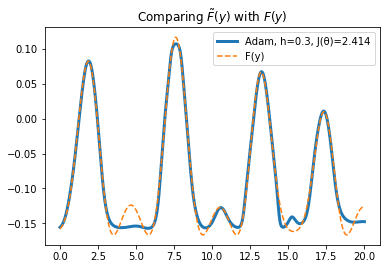

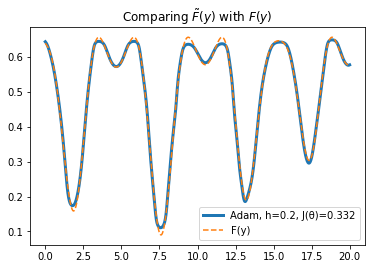

In [ ]:
"""Show approximation to the last trained data"""
batchLast = batch = generate_data(batchTo)
CV = batchLast['V'][dataPointsFrom:dataPointsTo]
CT = batchLast['T'][dataPointsFrom:dataPointsTo]
t = batchLast['t'][dataPointsFrom:dataPointsTo]
plotApprox(CV, adamOptV, x=t)
plotApprox(CT, adamOptT, x=t)

The choice of $K$, $h$ and maximum number of iterations were found by starting with the params found in section 2 (b). From there on the cells above were rerun with minor tweaks of the parameters resulting in the ones used in this run. As seen above, the model approximates the training data with $J(\theta) < 3$.

## (g) Test on untrained data batch

In [ ]:
# Setup test batch
testBatch = generate_data(batchTo+1)
ttest = testBatch['t']
# Potential
Y0testQ = testBatch['Q']
CtestV = testBatch['V']
# Kinetic
Y0testP = testBatch['P']
CtestT = testBatch['T']

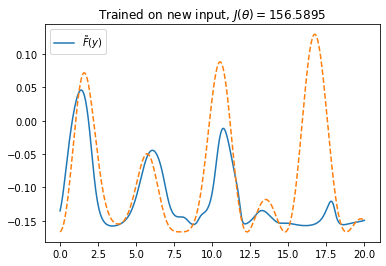

In [ ]:
testOnNew(Y0testQ, CtestV, ttest, adamOptV)

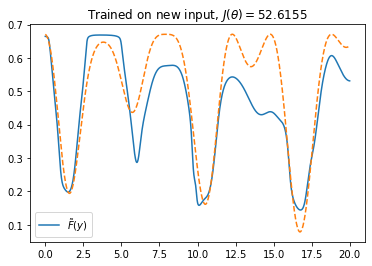

In [ ]:
testOnNew(Y0testP, CtestT, ttest, adamOptT)

By having 3000 iterations on training batches one can se an apparent approximation to the excact output. Below it is tested on another untrained batch.

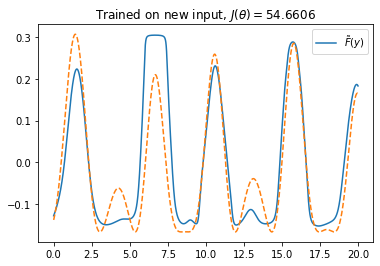

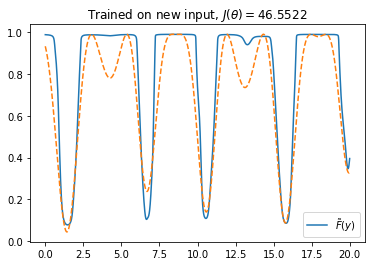

In [ ]:
# Setup test batch number 2
testBatch = generate_data(batchTo+2)
ttest = testBatch['t']
# Potential
Y0testQ = testBatch['Q']
CtestV = testBatch['V']
# Kinetic
Y0testP = testBatch['P']
CtestT = testBatch['T']

testOnNew(Y0testQ, CtestV, ttest, adamOptV)
testOnNew(Y0testP, CtestT, ttest, adamOptT)

# 3. Computing gradient of the trained function

The network uses a recursive procedure to approximate a function through $K$ layers. The approximation after each run of the training function, $Z^K$, is calculated by $ Z^{(k+1)} = \Phi_k(Z^{(k)})$ for $k = 0,1,\ldots, K-1$ where $Z^{(0)}$ is given.

$\Phi_k(y) = y + h\sigma (W_k y+b_k),  k = 0,\ldots, K -1,  $$\Phi_K =G(y) = \eta(w^T y + \mu).$ 



$F(y)$ can thus be written as
 $$
 F(y) = G \circ \Phi_{K-1} \circ \Phi_{K-2} \circ \ldots \circ \Phi_0 = G\circ \Phi
 $$

 
The trained function $F:\mathbb{R}^d \rightarrow \mathbb{R} $ is a differentiable function for which the gradient is sought. It is now expressed as a composite function $F(y) = G \circ \Phi(y) = G(\Phi(y))$ where $G:\mathbb{R}^d \rightarrow \mathbb{R} $ and $\Phi:\mathbb{R}^d \rightarrow \mathbb{R}^d $


By the chain rule, the $i$'th element of the gradient of such a function can be expressed as
$$
[\nabla F(y)]_i = \frac{\delta F}{\delta y_i} (y) = \sum_{j=1}^d \frac{\delta G}{\delta z_j} (z) \frac{\delta \Phi_j}{\delta y_i} (y)
$$


The expression can be rewritten by using the  gradient of $G(z)$, and the Jacobian matrix of $\Phi$, $D\Phi$ containing the elements $\frac{\delta \Phi_j}{\delta y_i}$. 

$$
[\nabla F(y)]_i = \sum_{j=1}^d \frac{\delta \Phi_j}{\delta y_i} (y) [\nabla G(z)]_j =  \sum_{j=1}^d [D\Phi(y)]_{ji} [\nabla G(z)]_j
$$

Thus with $z = \Phi(y)$
 

$\nabla F(y) = (D\Phi(y))^T\nabla G(z)$

 
 
 By defining functions
 
 $$
 \Psi_0 = \Phi_0, \Psi_k = \Phi_k \circ \Psi_{k-1} = \Phi_k \circ \ldots \circ \Phi_0,  k = 1,\ldots , K-1.
 $$
 
  $Z^{(K)}$ can be expressed recursively
 
 $$
 Z^{(K)} = \Psi_{K-1}(y) = \Phi_{K-1}(Z^{(K-1)}) = \Phi_{K-1}\circ \Psi_{k-2}(y) = \ldots
 $$
 
 The gradient of the trained function can now be written as
 
$$
\nabla F(y) = (D\Psi_{K-1}(y))^T\nabla G(Z^{(K)})
$$

where
 
 $$
 (D\Psi_{k-1}(y))^T = (D\Phi_{k-1}(Z^{(k-1)}) \cdot D\Psi_{K-2}(y))^T = (D\Psi_{K-2}(y))^T \cdot (D\Phi_{k-1}(Z^{(k-1)}))^T
 $$

This process can be continued all the way down. At the start of each iteration though the the network, all $Z^{(k)} $ are computed with a forward sweep. Then the gradient of the trained function can be computed by an algorithm 


$A = \nabla G(Z^{(K)})$ \\
for $k$ in range$(K,0,-1)$: \\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$A = (D\Phi_{k-1}(Z^{(k-1)})^T A$ 
<br>




Looking at the function $G$ component-wise and taking the derivative, one can find the first gradient required in the algorithm

$$
G(y) = \eta(\sum_{i=1}^d\omega_i y_i + \mu)
\implies 
\frac{\delta G}{\delta y_j} = \eta'(\sum_{i=1}^d \omega_i y_i + \mu)\omega_j
\implies
\nabla G(y) = \eta'(\omega^Ty + \mu)\omega.
$$

Now with $\Phi_k$ for $k = 0,1\ldots,K-1$
$$
[\Phi(y)]_i = y_i + h\sigma(\sum_{j=1}^d W_{ij} y_j + b_i) 
\implies
\frac{\delta \Phi_i}{\delta y_r} = \delta_{ir} + h\sigma`(\sum_{j=1}^d W_{ij} y_j + b_i) W_{ir}
$$

In the for-loop in the algorithm, for a vector $A$, the expression $(D\Phi(y))^TA$ must be computed. The $r$'th component of this product is

$$
\sum_{i=1}^d[D\Phi(y)]_{ir}A_i = A_r +h\sum_{i=1}^d\sigma`(\sum_{j=1}^dW_{ij} y_j + b_i)W_{ir}A_i
$$

Defining $B_i =h\sigma`(\sum_{j=1}^d W_{ij} y_j + b_i)$ the last term can be written as $\sum_{i=1}^dW_{ir}(A_iB_i)$. As $A_iB_i = (A\odot B)_i $ the matrix-vector product in the algorithm can be expressed as

$$
D\Phi(y)^TA = A + W^T(h\sigma`(Wy+b)\odot A)
$$




# 4. Implementation of the models gradient function
The algorithm for cumputing the models gradient is implemented in the "Model" class as "getGrads".

# 5. 

### Symplectic Euler and Størmer-Verlet method

The symplectic Euler method and The Størmer verlet has been used on the 3 different Hamiltonians. These methods can be used on partioned systems. The symplectic Euler method treats the one variable by the implicit- and the other by the explicit Euler method. The Størmer-verlet method is of order two, and it is expected it to give more accurate results on the Hamiltonian systems. To use these methods, one has to find the gradients of the hamiltonians. The Hamiltonian for a nonlinear pendelum is given by
$$
H_1(p,q)=\frac{1}{2} p^{2} + mgl(1-\cos(q))=T_1(p)+V_1(q)
$$
The gradients are therefore

$$
\frac{\partial H_1}{\partial p}=\frac{\partial T_1}{\partial p}=p
\\
\frac{\partial H_1}{\partial q}=\frac{\partial V_1}{\partial q}=mgl \sin(q)
$$.

We check the value for the Hamiltonian for the staring values we choose. We choose the starting values to be $q_0=1$ and $p_0=0$. We use $m=1.00$ and $l=0.50$. From these values, we expect the starting value to be $H_{10}=2.25$, and we are going to check if the Hamiltonian is preserved along the $n$-values.
<br>
The second problem that has been solved is the Kepler two-body problem, which has the the Hamiltonian given by

$$
H_2(p,q)=T_2(p)+V_2(q)=\frac{1}{2} p^T p-\frac{1}{\sqrt{q_1^2+q_2^2}}.
$$
The gradients of this hamiltonian is given by

$$
\frac{\partial H_2}{\partial p}=\frac{\partial T_2}{\partial p}=\left[\frac{\partial T_2}{\partial p_1}, \frac{\partial T_2}{\partial p_2} \right]^T=  \left[{p_1},{p_2} \right]^T
\\
\frac{\partial H_2}{\partial q}=\frac{\partial V_2}{\partial q}=\left[\frac{\partial T_2}{\partial q_1}, \frac{\partial T_2}{\partial q_2} \right]^T=  \left[\frac{q_1}{(q_1^2+q_2^2)^{3/2}}, \frac{q_2}{(q_1^2+q_2^2)^{3/2}} \right]^T.
$$
We want to see how the Hamiltonian is preserved along $n$. We use staring values 
$$
q_0=[q_{10}, q_{20}]=[1-e,0], p_0=[p_{10},p_{20}]=\left[ 0,\frac{1+e}{1-e} \right]
$$ 

with $0< e< 1$. For these values,  $H_2=-0.5$, which can be seen by inserting these points in the expression for $H_2$. We use $e=0.5$.
<br>
The Henon-Heiles problem is given by the Hamiltonian

$$
H_3(p,q)=T_3(p)+V_3(q)=\frac{1}{2} p^T p-\frac{1}{2}q^Tq+q_1^2 q_2-\frac{1}{3} q_2^3
$$,

and the gradients given by

$$
\frac{\partial H_3}{\partial p}=\frac{\partial T_3}{\partial p}=\left[\frac{\partial T_3}{\partial p_1}, \frac{\partial T_3}{\partial p_2} \right]^T=  \left[{p_1},{p_2} \right]^T
\\
\frac{\partial H_3}{\partial q}=\frac{\partial V_3}{\partial q}=\left[\frac{\partial T_3}{\partial q_1}, \frac{\partial T_3}{\partial q_2} \right]^T=[q_1+2q_1q_2,q_2+q_1^2-q_2^2]^T.
$$

We set $H_3=1/12$ for the Henon-Heiles problem, and want to check if the Hamiltonian is preserved along the n-values. We put $q_{10}=0$. Then for for example a point $q_{20}=0.1$ and $p_{20}=0.1$. From there, we find
$$
p_{10}=\sqrt{2H-2V-p_{20}^2}=\sqrt{2\frac{1}{12}-2\frac{7}{1500}-0.1^2}=0.38384
$$. We use these as starting points for the numerical methods.

The numerical methods with exact gradients will be compared to the numerical solutions using gradients calculated with the parameters obtained from training the neural network on $T$ and $V$.


## Functions for symplectic Euler and the Størmer-Verlet method for the Hamiltonian function

In [ ]:
# Functions for exact gradients
# gradient of Hamiltonian in non linear pendelum
# The first coordinate returned is the deriate of T 
# with respect to p and the second V with respect to q
def grad1(qn, pn):
    return pn, m*g*l*np.sin(qn)

# gradient of Hamiltonian in Kepler two-body problem for a specific q and p
# dp_1. The derivate of T. dq_1 is the derivate of V. both with two coordinates


def grad2(qn, pn):
    dT = np.zeros(2)  # dT=dT/dp a 2x1 vector
    dV = np.zeros(2)  # dV=dV/dq a 2x1 vector
    dT[0] = pn[0]  # dT[0]=p_1
    dT[1] = pn[1]  # dT[1]=p_2
    dV[0] = (qn[0])/((qn[0]**2+qn[1]**2)**(3/2))  # dV[0]
    dV[1] = ((qn[1])/((qn[0]**2+qn[1]**2)**(3/2)))
    return dT, dV

# gradient of Hamiltonian in Henon-heiles problem


def grad3(qn, pn):
    dT = np.zeros(2)  # dT=dT/dp a 2x1 vector
    dV = np.zeros(2)  # dV=dV/dp a 2x1 vector
    dT[0] = pn[0]  # dT[0]=p_1
    dT[1] = pn[1]  # dT[1]=p_2
    dV[0] = qn[0]+2*qn[0]*qn[1]  # dV[0]
    dV[1] = qn[1]+qn[0]**2-qn[1]**2  # dV[0]
    return dT, dV

# The symplectic Euler method with exact gradients    
def symEuler(tot_t,T,V,q0,p0,h,grad,dim):
    if dim>1:
        A=np.zeros((2,N+1,dim))
    if dim==1:
        A=np.zeros((2,N+1))
    ### A[0]=qn and A[1]=pn
    
    A[0,0], A[1,0] = q0, p0
    
    ### Create arrays for H, V and T and set the startvalues
    H=np.zeros((N+1))
    Vlist=np.zeros((N+1))
    Tlist=np.zeros((N+1))
    Vlist[0]=V(A[0,0])
    Tlist[0]=T(A[1,0])
    H[0]=Tlist[0]+Vlist[0]
    for n in range(N):
        qn,pn=A[0,n],A[1,n]
        dp=grad(qn,pn)[0]
        A[0,n+1]=A[0,n]+h*dp
        qn1=A[0,n+1]
        dq1=grad(qn1,pn)[1]
        A[1,n+1]=A[1,n]-h*dq1
        ###Use qn and pn to store the next value of V and T and H
        Vlist[n+1]=V(A[0,n+1])
        Tlist[n+1]=T(A[1,n+1])
        H[n+1]=Tlist[n+1]+Vlist[n+1]
    return A,H,Vlist,Tlist

##SymEuler for with trained gradients
def symEulerOpt(N, h, q0, p0, optT, optV):
    num_p = np.zeros((N+1,1))
    num_q = np.zeros((N+1,1))
    num_q[0]=q0
    num_p[0]=p0    
    for n in range(N):
        num_q[n+1]=num_q[n] + h * optT.M.computeGradYn(np.array([num_p[n], 0]).reshape((2,1)))[0]
        num_p[n+1]= num_p[n] - h * optV.M.computeGradYn(np.array([num_q[n+1],0]).reshape((2,1)))[0]
    return num_q, num_p

##Størmer-verlet method with trained gradients
def Størmer_verletOpt(N, h, q0, p0, optT, optV):
    num_p = np.zeros((N+1,1))
    num_q = np.zeros((N+1,1))
    num_q[0]=q0
    num_p[0]=p0    
    for n in range(N):
        pn12=num_p[n]-h*optT.M.computeGradYn(np.array([num_q[n], 0]).reshape((2,1)))[0]
        num_q[n+1]=num_q[n] + h * optT.M.computeGradYn(np.array([pn12, 0]).reshape((2,1)))[0]
        num_p[n+1]= num_p[n] - h * optV.M.computeGradYn(np.array([num_q[n+1],0]).reshape((2,1)))[0]
    return num_q, num_p

### Størmer verlet method with exact gradients ###
def Stormer_verlet(tot_t,T,V,q0,p0,h,grad,dim):
    ###Create A which stores qn values in A[0] and pn values in A[1]
    if dim==1:
        A=np.zeros((2,N+1))
    if dim>1:
        A=np.zeros((2,N+1,dim))
    A[0,0], A[1,0]= q0, p0
    
    ###Create arrays for H, V and T and set the start values
    H=np.zeros((N+1))
    Vlist=np.zeros((N+1))
    Tlist=np.zeros((N+1))
    Vlist[0]=V(A[0,0])
    Tlist[0]=T(A[1,0])
    H[0]=Tlist[0]+Vlist[0]
    for n in range(N):
        qn,pn=A[0,n],A[1,n]
        dq=grad(qn,pn)[1]
        pn_12=pn-(h/2)*dq
        dp_12=grad(qn,pn_12)[0]
        A[0,n+1]=qn+h*dp_12
        qn1=A[0,n+1]
        dqn1=grad(qn1,pn)[1]
        A[1,n+1]=pn_12-(h/2)*dqn1
        ###Use qn and pn to store the next value of V and T and H 
        Vlist[n+1]=V(A[0,n+1])
        Tlist[n+1]=T(A[1,n+1])
        H[n+1]=Tlist[n+1]+Vlist[n+1]
    return A,H,Vlist,Tlist
   
   # Functions fo  
   


# Set the start values

In [ ]:


q0_n=1 #starting value for q in nonlinear pendelum
p0_n=0  #Starting value for p in nonlinear pendelum
q0_k,p0_k=np.array([1-0.5,0]), np.array([0,np.sqrt(((1+0.5)/(1-0.5)))]) #Starting values for q and p in two kepler body
### The calculated starting value p10 i henon heiles problem
p10=np.sqrt(2*(1/12)-2*(7/1500)-0.1**2)
q0_h, p0_h=np.array([0,0.1]), np.array([p10,0.1]) # starting values for q and p in Henon Heiles problem

m=1.0 #mass in nonlinear pendelum
g=9.81 #Gravitational acceleration
l=0.50 #length of pendelum
# setup
N=4096 #number of n
tot_t=10 #total time
h=tot_t/N #timestep

#Symplectic Euler for method for nonlinear pendelum
A,H_0,V_0,T_0=symEuler(tot_t,T_H_1,V_H_1,q0_n,p0_n,h,grad1,1)
#A contains all q and p values obtained from the method for nonlinear pendelum

#Størmer verlet method for nonlinear pendelum
B,H_1,V_1,T_1=Stormer_verlet(tot_t,T_H_1,V_H_1,q0_n,p0_n,h,grad1,1)
#B contains all q and p values obtained from the method for nonlinear pendelum

#Symplectic Euler method for Kepler two-body problem
C,H_2,V_2,T_2=symEuler(tot_t,T_H_2,V_H_2, q0_k,p0_k, h, grad2,2)
#C contains all q and p values obtained from the method for kepler two-body 

#Størmer verlet method for kepler two-body problem
D,H_3,V_3,T_3=Stormer_verlet(tot_t,T_H_2,V_H_2, q0_k,p0_k, h, grad2,2)
#D contains all q and p values obtained from the method for Kepler two-body

#Størmer verlet method for Henon Heiles problem 
E,H_4,V_4,T_4=Stormer_verlet(tot_t,T_H_3,V_H_3, q0_h,p0_h, h, grad3,2)
#E contains all q and p values obtained from the method for Henon Heiles

#Symplectic Euler method for Henon Heiles problem
F,H_5,V_5,T_5=symEuler(tot_t,T_H_3,V_H_3, q0_h,p0_h, h, grad3,2)
#F contains all q and p values obtained from the method for Henon Heiles

### Test on trained network

Using a simple hypothesis function to avoid scaling

In [ ]:
def η(x):
    return x


def dη(x):
    return np.ones_like(x)

Here the network is trained on the functions from the nonlinear pendulum problem, for values of q and p ranging from -5 to 5. From this finished function approximation, the network gradient can be calculated for any input q and p, and thus be used in the symplectic Euler method. 

In [ ]:
tot_t=10
h=0.2
tol = 1e-4
maxiter = 1e4
dt=tot_t/N

q = np.linspace(-5,5,700)
p =np.linspace(-5,5,700)

qMod = np.array([q, np.zeros_like(q)])
pMod = np.array([p, np.zeros_like(p)])

T = T_H_1(p.copy())
V = V_H_1(q.copy())

modT =Model(pMod, T, 15)
adamT = Adam(modT)
modV = Model(qMod, V, 15)
adamV = Adam(modV)
adamT.run(h, tol, maxiter)
adamV.run(h, tol, maxiter)

0.004507823185949322
0.005667710012638204


In [ ]:
## Using symplectic Euler with the trained network 
Eul_numQ,Eul_numP = symEulerOpt(N, dt, q0_n, p0_n, adamT, adamV)

##Using Størmer-verlet with the trained network
st_numQ, st_numP=Størmer_verletOpt(N, dt, q0_n, p0_n, adamT, adamV)
# Check the Hamiltonian for the q and p found be sym_Euler with gradients from network

#T , V and H for symplectic Euler with network gradient
T_net0=T_H_1(Eul_numP)
V_net0=V_H_1(Eul_numQ)
H_net0=T_net0+V_net0

#T, V and H for Størmer-verlet with network gradient
T_net1=T_H_1(st_numP)
V_net1=V_H_1(st_numQ)
H_net1=T_net1+V_net1

H_exc=T_H_1(A[1,:])+V_H_1(A[0,:])

## 

# Plots of the numerical methods

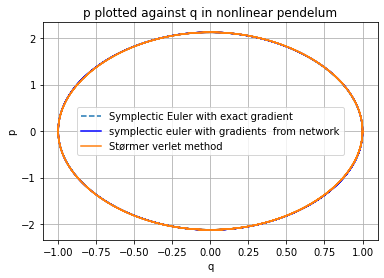

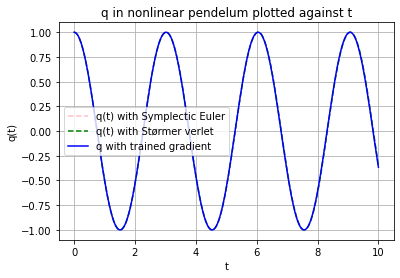

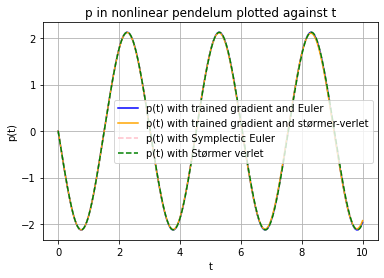

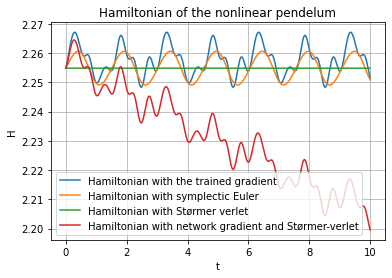

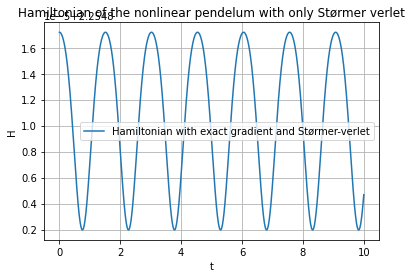

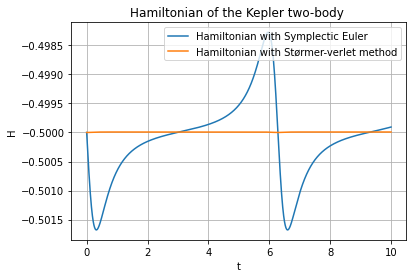

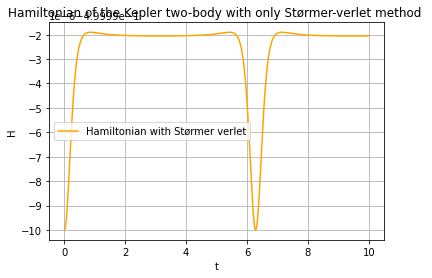

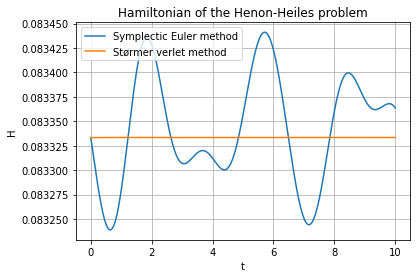

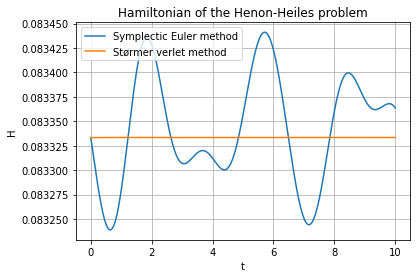

In [ ]:



### Plots ###

##plot the Hamiltonians along t-values which are the n-values times the timestep
t = np.array([i*dt for i in range(N+2)])

###Plot for p against q in nonlinear pendelum. A[0]=q-values A[1]=p-values obtained from the euler method
###B[0]=q-values and B[1]=p-values obtained from Størmer-verlet method
plt.figure()
plt.grid()
plt.title("p plotted against q in nonlinear pendelum")
plt.xlabel("q")
plt.ylabel("p")
plt.plot(A[0,:],A[1,:], label="Symplectic Euler with exact gradient", ls="--")
plt.plot(Eul_numQ, Eul_numP, label="symplectic euler with gradients  from network", color='blue')
plt.plot(B[0,:],B[1,:], label="Størmer verlet method")
plt.legend()
plt.show()


###Plot q with both methods
plt.figure()
plt.grid()
plt.title("q in nonlinear pendelum plotted against t")
plt.xlabel("t")
plt.ylabel("q(t)")
plt.plot(t[:-1],A[0,:], label="q(t) with Symplectic Euler", ls="--",color='pink' )
plt.plot(t[:-1],B[0,:], label="q(t) with Størmer verlet", ls="--", color='green')
plt.plot(t[:-1], Eul_numQ, label='q with trained gradient', color='blue')
plt.legend()
plt.show()

###Plot p with both methods
plt.figure()
plt.grid()
plt.title("p in nonlinear pendelum plotted against t")
plt.xlabel("t")
plt.ylabel("p(t)")
plt.plot(t[:-1], Eul_numP, label='p(t) with trained gradient and Euler', color='blue')
plt.plot(t[:-1], st_numP, label='p(t) with trained gradient and størmer-verlet', color='orange')
plt.plot(t[:-1],A[1,:], label="p(t) with Symplectic Euler", ls="--",color='pink' )
plt.plot(t[:-1],B[1,:], label="p(t) with Størmer verlet", ls="--", color='green')
plt.legend()
plt.show()

###Plot The hamiltonian of nonlinear pendelum with both methods
plt.figure()
plt.grid()
plt.xlabel("t")
plt.ylabel("H")
plt.title("Hamiltonian of the nonlinear pendelum")
plt.plot(t[:-1],H_net0, label="Hamiltonian with the trained gradient ")
plt.plot(t[:-1],H_exc, label="Hamiltonian with symplectic Euler")
plt.plot(t[:-1],H_1, label="Hamiltonian with Størmer verlet")
plt.plot(t[:-1], H_net1,label="Hamiltonian with network gradient and Størmer-verlet" )
plt.legend()
plt.show()

###Plot of Hamiltonians for nonlinear pendelum with størmer verlet 
plt.figure()
plt.grid()
plt.xlabel("t")
plt.ylabel("H")
plt.title("Hamiltonian of the nonlinear pendelum with only Størmer verlet")
plt.plot()
plt.plot(t[:-1],H_1, label="Hamiltonian with exact gradient and Størmer-verlet")
plt.legend()
plt.show()

###Plot of hamiltonians for Kepler two-body with euler and størmer
plt.figure()
plt.grid()
plt.xlabel("t")
plt.ylabel("H")
plt.title("Hamiltonian of the Kepler two-body ")
plt.plot(t[:-1],H_2, label ="Hamiltonian with Symplectic Euler")
plt.plot(t[:-1],H_3, label="Hamiltonian with Størmer-verlet method" )
plt.legend()
plt.show()

###Plot of hamiltonians of two-kepler body
plt.figure()
plt.grid()
plt.xlabel("t")
plt.ylabel("H")
plt.title("Hamiltonian of the Kepler two-body with only Størmer-verlet method ")
plt.plot(t[:-1],H_3, label="Hamiltonian with Størmer verlet", color='orange' )
plt.legend()
plt.show()

###Plot of Hamiltonians of Henon Heiles
plt.figure()
plt.grid()
plt.xlabel("t")
plt.ylabel("H")
plt.title("Hamiltonian of the Henon-Heiles problem")
plt.plot(t[:-1],H_5,label= "Symplectic Euler method")
plt.plot(t[:-1],H_4,label= "Størmer verlet method")
plt.legend()
plt.show()

plt.figure()
plt.grid()
plt.xlabel("t")
plt.ylabel("H")
plt.title("Hamiltonian of the Henon-Heiles problem")
plt.plot(t[:-1],H_5,label= "Symplectic Euler method")
plt.plot(t[:-1],H_4,label= "Størmer verlet method")
plt.legend()
plt.show()


### Answer 5b.)


#### Nonlinear pendelum:
The first plot show $q$ plotted against $p$ with the two numerical methods, and it shows that the solution is periodical, which is expected with a nonlinear pendelum since it swings back and forth. The second plot shows how $q$ changes with time, and it also shows a periodical solution. The gradient calculated from the network give pretty accurate results for the three first plots. We see however that the Hamiltonian have a different oscillation for the plots with gradients computed from the network, epscially for the Størmer-verlet method, which seem to oscillate around a straight line. This suggest that the formula for the numerical gradient is innaccurate or that the network is not properly trained.  The størmer verlet method is supposed to give much smaller error for the hamiltonian, which is expected to be around $2.25$. We see that størmer verlet with exact gradient gives a result with much less error.
 
#### Kepler two-body:
The starting value of the Hamiltionian was calculated to be $-0.50$. We see that the numerical solution oscillates around $-0.50$, but with much smaller oscilation for the Størmer verlet method, which is expected because it has a higher order. We expect the error in $H$ to be $O(h)$ for symplectic Euler and $O(h^2)$ for Størmer_verlet, where $h$ is the stepsize.

#### Henon Heiles:
We wanted to check if the Hamiltonian was preserved as $H=\frac{1}{12}=0.08333.$ .The numerical solution with symplectic euler oscillate around the expected value, while the Størmer verlet seem to preserve the Hamiltonian close to $\frac{1}{12}$. In the plot with only the Størmer-verlet method, we see that there is small oscillation with this method too.

The gradient calculated from the network gave very innaccurate results and they are not included here.

### c)

In [ ]:
def symEulerOpt2D(N, h, q0, p0, optT, optV):
    dt = optT.M.d
    dv = optV.M.d
    num_p = np.zeros((N+1, dt, 1))
    num_q = np.zeros((N+1, dv, 1))
    num_q[0] = q0
    num_p[0] = p0
    for n in range(N):
        num_q[n+1] = num_q[n]+h*optT.M.computeGradYn(num_p[n].reshape(dt, 1))
        num_p[n+1] = num_p[n]-h*optV.M.computeGradYn(num_q[n+1].reshape(dv, 1))
    return num_q, num_p

ttest = testBatch['t']
# Potential
Y0testQ = testBatch['Q']
CtestV = testBatch['V']
# Kinetic
Y0testP = testBatch['P']
CtestT = testBatch['T']

dt = ttest[1] - ttest[0]
num2Q, num2P = symEulerOpt2D(N, dt,  np.reshape(Y0testQ[:, 0],(3,1)), np.reshape(Y0testQ[:, 0],(3,1)), adamOptT, adamOptV)



(3,)


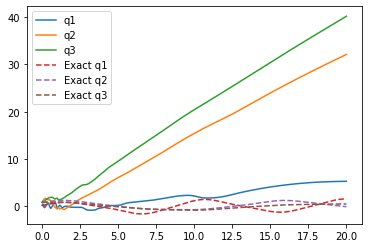

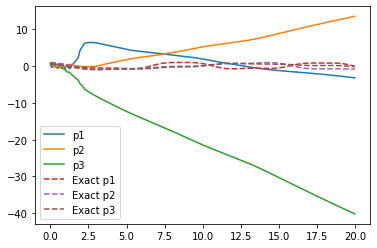

In [ ]:
plt.plot(ttest, num2Q[:-1, 0], label='q1')
plt.plot(ttest, num2Q[:-1, 1], label='q2')
plt.plot(ttest, num2Q[:-1, 2], label='q3')
plt.plot(ttest, Y0testQ[0], label='Exact q1', ls='--')
plt.plot(ttest, Y0testQ[1], label='Exact q2', ls='--')
plt.plot(ttest, Y0testQ[2], label='Exact q3', ls='--')
plt.legend()

plt.figure()
plt.plot(ttest, num2P[:-1, 0], label='p1')
plt.plot(ttest, num2P[:-1, 1], label='p2')
plt.plot(ttest, num2P[:-1, 2], label='p3')
plt.plot(ttest, Y0testP[0], label='Exact p1', ls='--')
plt.plot(ttest, Y0testP[1], label='Exact p2', ls='--')
plt.plot(ttest, Y0testP[2], label='Exact p3', ls='--')
plt.legend()
plt.show()

The plots show a deviation from exact values with magnitude up to 40 units. As seen in the plots of the models approximation of a new, untrained problem, there is also a deviation. Since the method used to get the trajectories in the plots above is calculated by the gradients the model approximates by approximating a new unknown problem, the deviation seems appropriate. Moreover, each step with slight deviation adds to the next steps deviation, thus resulting in larger deviation towards the last steps.